Epoch  10/200  Loss=2.1558e+00  Valid Loss=2.4025e-01  LR=1.00e-03
Epoch  20/200  Loss=4.1846e-01  Valid Loss=7.8855e-02  LR=1.00e-03
Epoch  30/200  Loss=2.4390e-01  Valid Loss=4.6777e-02  LR=1.00e-03
Epoch  40/200  Loss=1.9782e-01  Valid Loss=3.6058e-02  LR=1.00e-03
Epoch  50/200  Loss=1.5272e-01  Valid Loss=2.7870e-02  LR=1.00e-03
Epoch  60/200  Loss=1.4513e-01  Valid Loss=2.6593e-02  LR=1.00e-03
Epoch  70/200  Loss=1.2933e-01  Valid Loss=2.4811e-02  LR=1.00e-03
Epoch  80/200  Loss=1.3233e-01  Valid Loss=2.4435e-02  LR=1.00e-03
Epoch  90/200  Loss=1.3043e-01  Valid Loss=3.7352e-02  LR=1.00e-03
Epoch 100/200  Loss=1.0669e-01  Valid Loss=2.0648e-02  LR=5.00e-04
Epoch 110/200  Loss=1.0435e-01  Valid Loss=2.1571e-02  LR=2.50e-04
Epoch 120/200  Loss=1.0002e-01  Valid Loss=2.0623e-02  LR=2.50e-04
Epoch 130/200  Loss=9.8340e-02  Valid Loss=1.9868e-02  LR=1.25e-04
Epoch 140/200  Loss=9.8243e-02  Valid Loss=1.9614e-02  LR=1.25e-04
Epoch 150/200  Loss=9.7429e-02  Valid Loss=1.9650e-02  LR=1.25

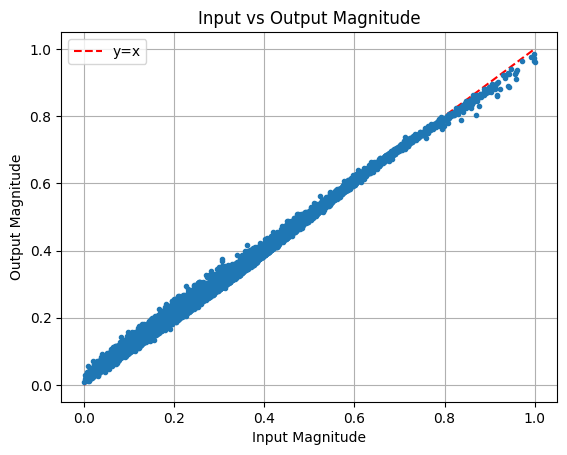

: 

In [ ]:
from sparseDPD import Volterra
from sparseDPD import Dataset
from sparseDPD import Datapath
from sparseDPD import DataManager
from sparseDPD import NeuralNetwork, PNTDNN, PNTDNN_3_layers

dataManager = DataManager(filepath='C:\\Users\\AQUIGNEY\\Documents\\College\\Project\\PA_IO.mat', num_training_points=10000, num_validaiton_points=2000, num_test_points=2000)


# Setup a volterra model and a volterra inverse
volterra_forward_model = Volterra(num_nl_orders=5, num_memory_levels=3, dataset=dataManager.training_dataset)
volterra_invserse_model = Volterra(num_nl_orders=5, num_memory_levels=3, dataset=dataManager.training_dataset)

training_dataset = dataManager.training_dataset

# Traing small Inverse Model 
nn_inv = NeuralNetwork(num_memory_levels=28, model_type='PNTDNN', forward_model=False)
best_nn_model = nn_inv.get_best_model(num_epochs=200, training_dataset=training_dataset, validation_dataset=dataManager.validation_dataset, learning_rate=1e-3)

# Create datapath with volterra forward model and nn inverse model
datapath = Datapath(forward_model=volterra_forward_model, inverse_model=nn_inv)
# Process test data through datapath
test_dataset = datapath.process(dataManager.test_dataset.input_data)
# Calculate NMSE
nmse = test_dataset.calculate_nmse()
print(f"Test NMSE: {nmse:.2f} dB")
# Plot input vs output magnitude
Datapath.plot_signals(test_dataset)